In [27]:
!pip install git+https://github.com/myerspat/pyMAISE.git

  Cloning https://github.com/myerspat/pyMAISE.git to /tmp/pip-req-build-76bb0fov
  Running command git clone --filter=blob:none --quiet https://github.com/myerspat/pyMAISE.git /tmp/pip-req-build-76bb0fov
  Resolved https://github.com/myerspat/pyMAISE.git to commit 3c3bf090ad6a32461aa80f7f1fdd6e0832d4c96c
  Preparing metadata (setup.py) ... done


In [28]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from scipy.stats import uniform, randint
from sklearn.preprocessing import Normalizer, MinMaxScaler

# Plot settings
matplotlib_settings = {
    "font.size": 12,
    "legend.fontsize": 11,
    "figure.figsize": (8, 8)
}
plt.rcParams.update(**matplotlib_settings)

In [29]:
from pyMAISE.preprocessing import correlation_matrix, train_test_split, scale_data
from pyMAISE.datasets import load_HTGR
import pyMAISE as mai

In [30]:
global_settings = mai.init(
    problem_type=mai.ProblemType.REGRESSION,   # Define a regression problem
    cuda_visible_devices="-1"                  # Use CPU only
)

In [31]:
# Get data
data, inputs, outputs = load_HTGR()

In [32]:
train_data, test_data = train_test_split(data=data, test_size=0.30)

theta_cols = [f"theta{i + 1}" for i in range(8)]
flux_cols = [f"fluxQ{i + 1}" for i in range(4)]

In [33]:
def mult_samples(data):
    # Create empty arrays
    ht = xr.DataArray(
        np.zeros(data.shape),
        coords={
            "index": [f"{idx}_h" for idx in data.coords["index"].values],
            "variable": data.coords["variable"],
        },
    )
    vt = xr.DataArray(
        np.zeros(data.shape),
        coords={
            "index": [f"{idx}_v" for idx in data.coords["index"].values],
            "variable": data.coords["variable"],
        },
    )
    rt = xr.DataArray(
        np.zeros(data.shape),
        coords={
            "index": [f"{idx}_r" for idx in data.coords["index"].values],
            "variable": data.coords["variable"],
        },
    )

    # Swap drum positions
    hkey = [f"theta{i}" for i in np.array([3, 2, 1, 0, 7, 6, 5, 4], dtype=int) + 1]
    vkey = [f"theta{i}" for i in np.array([7, 6, 5, 4, 3, 2, 1, 0], dtype=int) + 1]
    rkey = [f"theta{i}" for i in np.array([4, 5, 6, 7, 0, 1, 2, 3], dtype=int) + 1]

    ht.loc[:, hkey] = data.loc[:, theta_cols].values
    vt.loc[:, vkey] = data.loc[:, theta_cols].values
    rt.loc[:, rkey] = data.loc[:, theta_cols].values

    # Adjust angles
    ht.loc[:, hkey] = (3 * np.pi - ht.loc[:, hkey].loc[:, hkey]) % (2 * np.pi)
    vt.loc[:, vkey] = (2 * np.pi - vt.loc[:, hkey].loc[:, vkey]) % (2 * np.pi)
    rt.loc[:, rkey] = (np.pi + rt.loc[:, hkey].loc[:, rkey]) % (2 * np.pi)

    # Fill quadrant tallies
    hkey = [2, 1, 4, 3]
    vkey = [4, 3, 2, 1]
    rkey = [3, 4, 1, 2]

    ht.loc[:, [f"fluxQ{i}" for i in hkey]] = data.loc[:, flux_cols].values
    vt.loc[:, [f"fluxQ{i}" for i in vkey]] = data.loc[:, flux_cols].values
    rt.loc[:, [f"fluxQ{i}" for i in rkey]] = data.loc[:, flux_cols].values

    sym_data = xr.concat([data, ht, vt, rt], dim="index").sortby("index")

    # Normalize fluxes
    sym_data.loc[:, flux_cols].values = Normalizer().transform(sym_data.loc[:, flux_cols].values)

    # Convert global coordinate system to local
    loc_offsets = np.array(
        [3.6820187359906447, 4.067668586955522, 2.2155167202240653 - np.pi, 2.6011665711889425 - np.pi,
         0.5404260824008517, 0.9260759333657285, 5.3571093738138575 - np.pi, 5.742759224778734 - np.pi]
    )

    # Apply correct 0 point
    sym_data.loc[:, theta_cols] = sym_data.loc[:, theta_cols] - loc_offsets + 2 * np.pi

    # Reverse necessary angles
    sym_data.loc[:, [f"theta{i}" for i in [3,4,5,6]]] *= -1

    # Scale all to [0, 2 * np.pi]
    sym_data.loc[:, theta_cols] = sym_data.loc[:, theta_cols] % (2 * np.pi)

    return sym_data

In [34]:
sym_train_data = mult_samples(train_data)
sym_test_data = mult_samples(test_data)
print(f"Multiplied training shape: {sym_train_data.shape}, Multiplied testing shape: {sym_test_data.shape}")

Multiplied training shape: (2100, 12), Multiplied testing shape: (904, 12)


In [35]:
xtrain, xtest, _ = scale_data(sym_train_data.loc[:, theta_cols], sym_test_data.loc[:, theta_cols], MinMaxScaler())
ytrain, ytest, _ = scale_data(sym_train_data.loc[:, flux_cols], sym_test_data.loc[:, flux_cols], Normalizer(norm="l1"))

In [36]:
print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(2100, 8)
(904, 8)
(2100, 4)
(904, 4)


In [37]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [38]:
model = Sequential([
    Dense(236, activation='relu', input_shape=(8,)), #  Dropout(0.5)
    Dense(380, activation='relu', ),
    Dense(4, activation='linear', )
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=4.07e-4), loss='mse')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
history = model.fit(xtrain, ytrain, epochs=300, batch_size=8, verbose=1, validation_data=(xtest, ytest))

Epoch 1/300
263/263 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 0.0053 - val_loss: 4.8115e-04
Epoch 2/300
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 3.1797e-04 - val_loss: 1.5024e-04
Epoch 3/300
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.8891e-05 - val_loss: 5.4332e-05
Epoch 4/300
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.4675e-05 - val_loss: 4.1363e-05
Epoch 5/300
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 3.5760e-05 - val_loss: 4.1619e-05
Epoch 6/300
263/263 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 3.3451e-05 - val_loss: 3.6402e-05
Epoch 7/300
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.6777e-05 - val_loss: 2.8198e-05
Epoch 8/300
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5337e-05 - val_loss: 3.1400e-05
Epoch 9/300
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8257e-05 - val_loss: 2.4380e-05
Epoch 10/300
263/263 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.6748e-05 - val_loss: 2.9247e-05
Epoch 11/300
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/s

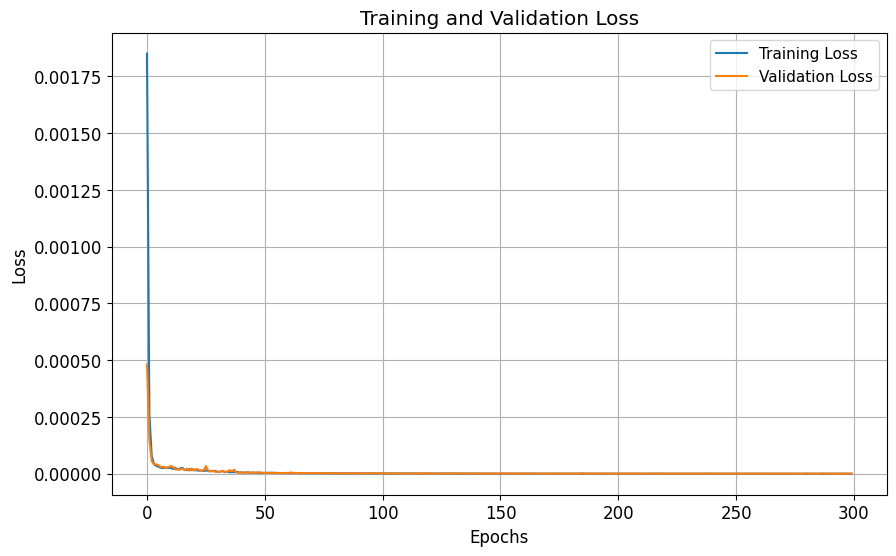

In [40]:
import matplotlib.pyplot as plt

# Extract loss values
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
xtrain_df = pd.DataFrame(xtrain, columns=theta_cols)
xtest_df = pd.DataFrame(xtest, columns=theta_cols)
ytrain_df = pd.DataFrame(ytrain, columns=flux_cols)
ytest_df = pd.DataFrame(ytest, columns=flux_cols)

# Export to CSV files
xtrain_df.to_csv("xtrain.csv", index=False)
xtest_df.to_csv("xtest.csv", index=False)
ytrain_df.to_csv("ytrain.csv", index=False)
ytest_df.to_csv("ytest.csv", index=False)

print("Exported xtrain, xtest, ytrain, and ytest to CSV files.")

Exported xtrain, xtest, ytrain, and ytest to CSV files.


In [42]:
y_train_pred = model.predict(xtrain)
y_test_pred = model.predict(xtest)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [44]:
print(ytrain.shape)
print(y_train_pred.shape)

(2100, 4)
(2100, 4)


In [45]:
mae_train = mean_absolute_error(ytrain, y_train_pred)
mse_train = mean_squared_error(ytrain, y_train_pred)
mape_train = np.mean(np.abs((ytrain - y_train_pred) / ytrain)) * 100
rmse_train = np.sqrt(mse_train)
rmspe_train = np.sqrt(np.mean(np.square((ytrain - y_train_pred) / ytrain))) * 100
r2_train = r2_score(ytrain, y_train_pred)

mae_test = mean_absolute_error(ytest, y_test_pred)
mape_test = np.mean(np.abs((ytest - y_test_pred) / ytest)) * 100
mse_test = mean_squared_error(ytest, y_test_pred)
rmse_test = np.sqrt(mse_test)
rmspe_test = np.sqrt(np.mean(np.square((ytest - y_test_pred) / ytest))) * 100
r2_test = r2_score(ytest, y_test_pred)

# Print results
print(f"Training Metrics:")
print(f"MAE: {mae_train:.4f}, MAPE: {mape_train:.4f}, MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, RMSPE: {rmspe_train:.4f}, R2: {r2_train:.4f}")

print(f"Test Metrics:")
print(f"MAE: {mae_test:.4f}, MAPE: {mape_test:.4f}, MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, RMSPE: {rmspe_test:.4f}, R2: {r2_test:.4f}")

Training Metrics:
MAE: 0.0005, MAPE: 0.1979, MSE: 0.0000, RMSE: 0.0006, RMSPE: 0.2462, R2: 0.9781
Test Metrics:
MAE: 0.0006, MAPE: 0.2377, MSE: 0.0000, RMSE: 0.0008, RMSPE: 0.3010, R2: 0.9698


In [52]:
data = np.hstack((xtest, ytest, y_test_pred))
columns = [f"x{i+1}" for i in range(xtest.shape[1])] + ["y1_test", "y2_test", "y3_test", "y4_test", "y1_test_pred", "y2_test_pred", "y3_test_pred", "y4_test_pred"]

# Create a DataFrame
df = pd.DataFrame(data, columns=columns)

# Export the DataFrame to a CSV file
output_file = "FNN_predictions.csv"
df.to_csv(output_file, index=False)

print(f"Predictions exported to {output_file}")

Predictions exported to FNN_predictions.csv
